# DCGAN on CIFAR-10 (Aligned with VAE)

This notebook implements a basic DCGAN using a generator and discriminator architecture similar in shape to the VAE's decoder and encoder, respectively. Optimizer, device selection, data loading, checkpointing cadence, and image save cadence mirror the VAE so you can compare architectures fairly.

In [20]:
# Imports and device setup
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils as vutils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

# Device selection aligned with VAE
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type.upper()}")

Using device: MPS


## Data Loading (same as VAE)

We use the same CIFAR-10 transforms and batch size as in `VAE.ipynb` to keep comparisons fair. Pixels are normalized to [-1, 1].

In [21]:
# Data loading: same transforms and batch size as VAE
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Fixed batch/noise for monitoring
fixed_batch = next(iter(test_loader))
fixed_noise = torch.randn(64, 64, device=device)  # latent_dim=64

## Models: Generator and Discriminator (VAE-aligned)

- Generator mirrors the VAE decoder: FC to 256x2x2 then ConvTranspose2d upsampling to 32x32x3 with Tanh.
- Discriminator mirrors the VAE encoder: Conv2d downsamples to 256x2x2, Flatten, then linear to a single logit.

In [22]:
# DCGAN Models

class Generator(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.latent_dim = latent_dim
        self.fc = nn.Linear(latent_dim, 256*2*2)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 2x2 -> 4x4
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 4x4 -> 8x8
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # 8x8 -> 16x16
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),     # 16x16 -> 32x32
            nn.Tanh(),
        )
    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 256, 2, 2)
        x = self.net(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # 32x32 -> 16x16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1), # 16x16 -> 8x8
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1), # 8x8 -> 4x4
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1), # 4x4 -> 2x2
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.classifier = nn.Linear(256*2*2, 1)  # outputs logit
    def forward(self, x):
        f = self.features(x)
        f = f.view(x.size(0), -1)
        logit = self.classifier(f)
        return logit.squeeze(1)

latent_dim = 64
G = Generator(latent_dim).to(device)
D = Discriminator().to(device)
print("Generator params:", sum(p.numel() for p in G.parameters())//1000, "K")
print("Discriminator params:", sum(p.numel() for p in D.parameters())//1000, "K")

Generator params: 756 K
Discriminator params: 691 K


## Training Setup and Loop (VAE-matched cadence)

- Optimizer: Adam(lr=1e-3) for both G and D to match VAE.
- Loss: BCEWithLogits for Discriminator and Generator (non-saturating G loss).
- Checkpoints: every 10 epochs, plus a latest file.
- Samples: save 8x8 grid every 20 epochs using a fixed noise vector for comparability.
- Resume: auto-load latest checkpoint if present.

In [23]:
# Training config and loop
criterion = nn.BCEWithLogitsLoss()
# optimizer_G = optim.Adam(G.parameters(), lr=1e-3)
# optimizer_D = optim.Adam(D.parameters(), lr=1e-3)
optimizer_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))


max_epochs = 150
ckpt_dir = './checkpoints_gan'
os.makedirs(ckpt_dir, exist_ok=True)
sample_dir = './gan_samples'
os.makedirs(sample_dir, exist_ok=True)

start_epoch = 0
latest_ckpt = os.path.join(ckpt_dir, 'gan_latest.pth')
if os.path.exists(latest_ckpt):
    ckpt = torch.load(latest_ckpt, map_location=device)
    G.load_state_dict(ckpt['G'])
    D.load_state_dict(ckpt['D'])
    optimizer_G.load_state_dict(ckpt['optG'])
    optimizer_D.load_state_dict(ckpt['optD'])
    start_epoch = ckpt['epoch']
    fixed_noise = ckpt.get('fixed_noise', fixed_noise)
    print(f"Resuming GAN training from epoch {start_epoch}")

# Utility to save samples
def save_samples(epoch):
    G.eval()
    with torch.no_grad():
        fake = G(fixed_noise).detach().cpu()
        fake = fake * 0.5 + 0.5  # denormalize to [0,1]
        grid = vutils.make_grid(fake, nrow=8, padding=2)
        plt.figure(figsize=(8,8))
        plt.axis('off')
        plt.title(f'GAN Samples - Epoch {epoch}')
        plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
        out_path = os.path.join(sample_dir, f'samples_epoch_{epoch}.png')
        plt.savefig(out_path)
        plt.close()
    G.train()

# Labels
real_label = 1.
fake_label = 0.

for epoch in range(start_epoch, max_epochs):
    G.train(); D.train()
    d_loss_epoch = 0.0
    g_loss_epoch = 0.0

    for real, _ in train_loader:
        real = real.to(device)
        bsz = real.size(0)

        # -----------------------------
        # Train Discriminator: maximize log D(x) + log(1 - D(G(z)))
        # -----------------------------
        optimizer_D.zero_grad()
        # Real
        logits_real = D(real)
        labels_real = torch.full((bsz,), real_label, device=device)
        loss_real = criterion(logits_real, labels_real)
        # Fake
        z = torch.randn(bsz, latent_dim, device=device)
        fake = G(z).detach()  # detach to avoid backprop to G
        logits_fake = D(fake)
        labels_fake = torch.full((bsz,), fake_label, device=device)
        loss_fake = criterion(logits_fake, labels_fake)
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # -----------------------------
        # Train Generator: maximize log D(G(z)) (non-saturating)
        # -----------------------------
        optimizer_G.zero_grad()
        z = torch.randn(bsz, latent_dim, device=device)
        fake = G(z)
        logits_fake = D(fake)
        labels_gen = torch.full((bsz,), real_label, device=device)
        loss_G = criterion(logits_fake, labels_gen)
        loss_G.backward()
        optimizer_G.step()

        d_loss_epoch += loss_D.item() * bsz
        g_loss_epoch += loss_G.item() * bsz

    n = len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{max_epochs} | D: {d_loss_epoch/n:.4f} | G: {g_loss_epoch/n:.4f}")

    # Save checkpoints every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch + 1,
            'G': G.state_dict(),
            'D': D.state_dict(),
            'optG': optimizer_G.state_dict(),
            'optD': optimizer_D.state_dict(),
            'fixed_noise': fixed_noise
        }, os.path.join(ckpt_dir, f'gan_checkpoint_epoch_{epoch+1}.pth'))
        torch.save({
            'epoch': epoch + 1,
            'G': G.state_dict(),
            'D': D.state_dict(),
            'optG': optimizer_G.state_dict(),
            'optD': optimizer_D.state_dict(),
            'fixed_noise': fixed_noise
        }, latest_ckpt)

    # Save samples every 20 epochs
    if (epoch + 1) % 20 == 0:
        save_samples(epoch + 1)

print("GAN Training complete!")

Resuming GAN training from epoch 20
Epoch 21/150 | D: 1.0818 | G: 1.2509
Epoch 22/150 | D: 1.0744 | G: 1.2539
Epoch 23/150 | D: 1.0660 | G: 1.2609
Epoch 24/150 | D: 1.0653 | G: 1.2801
Epoch 25/150 | D: 1.0589 | G: 1.2564
Epoch 26/150 | D: 1.0713 | G: 1.2577
Epoch 27/150 | D: 1.0580 | G: 1.2434
Epoch 28/150 | D: 1.0669 | G: 1.2552
Epoch 29/150 | D: 1.0574 | G: 1.2511
Epoch 30/150 | D: 1.0514 | G: 1.2697
Epoch 31/150 | D: 1.0479 | G: 1.2524
Epoch 32/150 | D: 1.0355 | G: 1.2551
Epoch 33/150 | D: 1.0303 | G: 1.2775
Epoch 34/150 | D: 1.0225 | G: 1.2867
Epoch 35/150 | D: 1.0269 | G: 1.3025
Epoch 36/150 | D: 1.0202 | G: 1.2747
Epoch 37/150 | D: 1.0165 | G: 1.2916
Epoch 38/150 | D: 1.0136 | G: 1.2968
Epoch 39/150 | D: 1.0102 | G: 1.2966
Epoch 40/150 | D: 1.0022 | G: 1.3028
Epoch 41/150 | D: 0.9965 | G: 1.3103
Epoch 42/150 | D: 0.9955 | G: 1.3175
Epoch 43/150 | D: 0.9896 | G: 1.3199
Epoch 44/150 | D: 0.9853 | G: 1.3346
Epoch 45/150 | D: 0.9736 | G: 1.3255
Epoch 46/150 | D: 0.9713 | G: 1.3294
Ep

KeyboardInterrupt: 

## Quick Sanity Checks and Visualization

- Verify generator output shape for a small batch.
- Generate and preview a grid of samples from fixed noise.
- Display saved sample grids over epochs to see progression.

Generator output shape: torch.Size([4, 3, 32, 32])


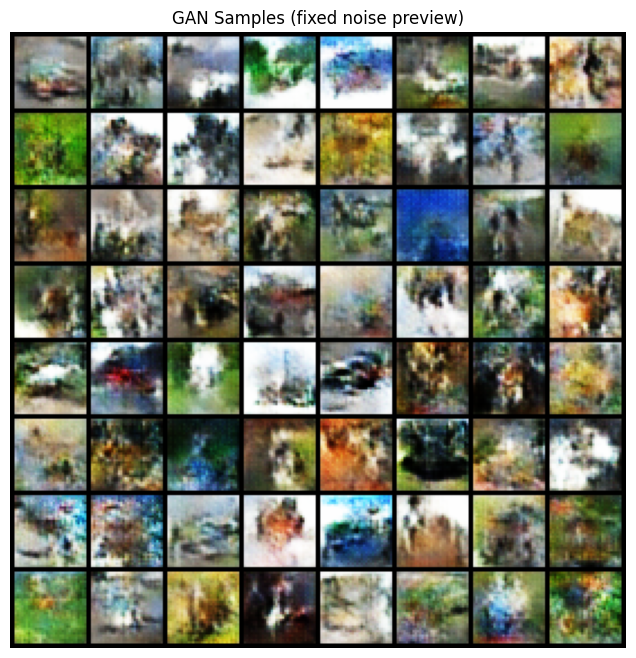

Found 1 saved GAN sample grids


AttributeError: 'Axes' object has no attribute 'reshape'

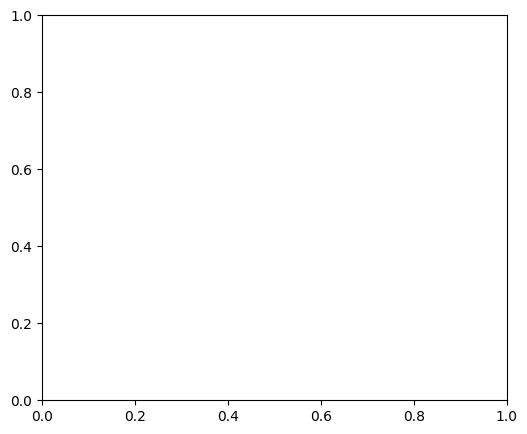

In [ ]:
# Sanity check: Generator output shape
G.eval()
with torch.no_grad():
    z = torch.randn(4, latent_dim, device=device)
    out = G(z)
    print('Generator output shape:', out.shape)
G.train()

# Preview a grid from fixed_noise (before training or after resume)
G.eval()
with torch.no_grad():
    preview = G(fixed_noise).detach().cpu()*0.5 + 0.5
    grid = vutils.make_grid(preview, nrow=8, padding=2)
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('GAN Samples (fixed noise preview)')
plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
plt.show()

# Display saved samples over epochs
import glob
from PIL import Image
sample_files = sorted(glob.glob(os.path.join(sample_dir, 'samples_epoch_*.png')))
if sample_files:
    print(f'Found {len(sample_files)} saved GAN sample grids')
    n_cols = min(3, len(sample_files))
    n_rows = (len(sample_files) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    for i, f in enumerate(sample_files):
        r, c = i // n_cols, i % n_cols
        img = Image.open(f)
        axes[r, c].imshow(img)
        ep = f.split('_')[-1].split('.')[0]
        axes[r, c].set_title(f'Samples - Epoch {ep}')
        axes[r, c].axis('off')
    for i in range(len(sample_files), n_rows*n_cols):
        r, c = i // n_cols, i % n_cols
        axes[r, c].axis('off')
    plt.suptitle('GAN Sample Grid Evolution (every 20 epochs)', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print('No saved GAN samples yet. Train the GAN or wait for the first 20-epoch save.')

## Load Latest GAN Checkpoint and Generate Samples

This cell restores the most recent GAN checkpoint (if available) and generates a sample grid from the fixed noise vector for quick inspection.

Loading GAN checkpoint: ./checkpoints_gan/gan_checkpoint_epoch_20.pth


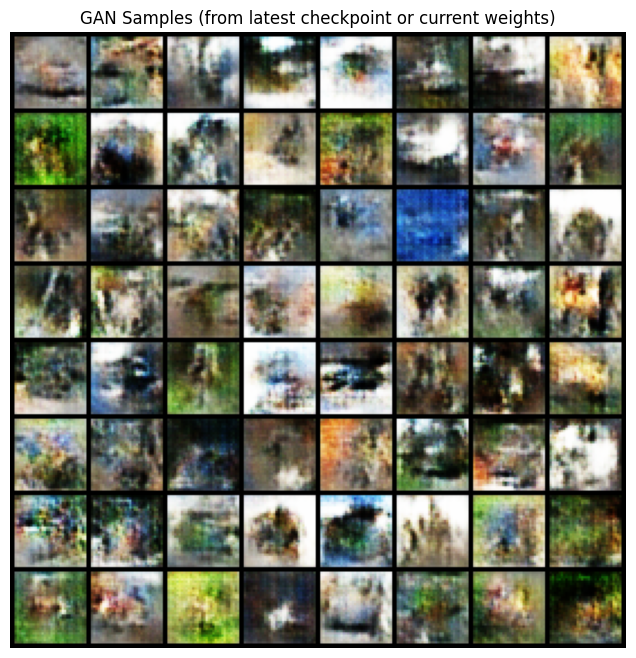

In [ ]:
# Load latest GAN checkpoint (if exists) and sample
import glob
latest = None
ckpts = glob.glob('./checkpoints_gan/gan_checkpoint_epoch_*.pth')
if ckpts:
    latest = max(ckpts, key=lambda p: int(p.split('_')[-1].split('.')[0]))
elif os.path.exists('./checkpoints_gan/gan_latest.pth'):
    latest = './checkpoints_gan/gan_latest.pth'

if latest:
    print(f"Loading GAN checkpoint: {latest}")
    state = torch.load(latest, map_location=device)
    G.load_state_dict(state['G'])
    D.load_state_dict(state['D'])
else:
    print('No GAN checkpoint found, using current weights.')

G.eval()
with torch.no_grad():
    preview = G(fixed_noise).detach().cpu()*0.5 + 0.5
    grid = vutils.make_grid(preview, nrow=8, padding=2)
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('GAN Samples (from latest checkpoint or current weights)')
plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
plt.show()